# Disaggregated population estimates: pre-requisites
* This notebook details the required data in order to carry out disaggregated population estimates

In [1]:
# snippet for relative imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path: sys.path.append(module_path)

import matplotlib.pyplot as plt
import osmnx as ox
import urbansprawl as us

ox.config(log_file=True, log_console=True, log_name='disaggregated_population_prerequisites', log_filename='disaggregated_population_prerequisites', use_cache=True)
figsize = (12,8)

# Extract gridded population count data

### Obtain the INSEE gridded population count data extract
* Resolution ~ 200 meters x 200 meters
* French country scope
* Download from the [INSEE site](https://www.insee.fr/fr/statistiques/2520034)
    * 1) Get the [Zip file](https://www.insee.fr/fr/statistiques/fichier/2520034/200m-carreaux-metropole.zip)
    * 2) Unzip
    * 3) Convert to [shapefile](https://en.wikipedia.org/wiki/Shapefile) using the following command (requires ogr2ogr):
            ogr2ogr -f 'ESRI Shapefile' carr_pop4326.shp car_m.mif -s_srs EPSG:27572 -t_srs EPSG:4326
    * 4) Place the files in `./data/insee/` folder (or any other desired folder)

### [Optional] Obtain the Gridded Population of the World (GPW) data extract
* Resolution ~ 1 km x 1 km
* World-wide scope
* Download from the [SEDAC site](http://sedac.ciesin.columbia.edu/data/collection/gpw-v4)
    * Convert to shapefile using the [Raster to vector](https://docs.qgis.org/2.14/en/docs/training_manual/complete_analysis/raster_to_vector.html) util of the [QGis Software](https://qgis.org/en/site/)

In [2]:
# Set the path to the INSEE population count data shapefiles
file_insee_shapefile = "./data/insee/carr_pop4326.shp"
file_insee_population_count = "./data/insee/car_m.dbf"

assert( os.path.isfile(file_insee_shapefile) )
assert( os.path.isfile(file_insee_population_count) )

# [Optional] set the path to the GPW population count data shapefile
file_gpw_shapefile = "./data/gpw/world_population.shp"

###  Extract population count data for a region of interest
* Lyon, France
    * INSEE French data (missing cells denote a null population)
    * Gridded Population of the World

In [3]:
# Get OSM data for: Lyon - Bounding box
city_ref = "Lyon"
east, north, south, west = 4.988479, 45.8421941, 45.6606074, 4.725495
region_args = {"east":east, "north":north, "south":south, "west":west}

%time lyon_buildings, lyon_building_parts, lyon_pois = us.get_processed_osm_data(city_ref=city_ref, region_args=region_args)
%time lyon_street_network = us.get_route_graph(city_ref)

CPU times: user 2h 11min 38s, sys: 32.6 s, total: 2h 12min 11s
Wall time: 2h 12min 14s
CPU times: user 16.5 s, sys: 429 ms, total: 16.9 s
Wall time: 18.4 s


### INSEE French population count data
* Resolution: 200m x 200m
* Coverage: France

CPU times: user 549 ms, sys: 8 ms, total: 557 ms
Wall time: 995 ms


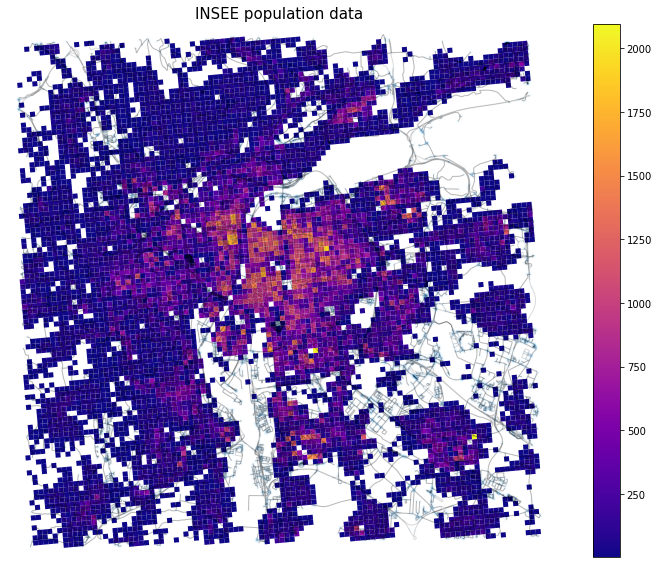

In [4]:
# Extract population count data for region of interest
%time lyon_pop_insee = us.get_extract_population_data(city_ref=city_ref, data_source="insee", to_crs=lyon_buildings.crs, pop_shapefile=file_insee_shapefile, pop_data_file=file_insee_population_count, polygons_gdf=lyon_buildings)

# Plot INSEE
fig, ax = ox.plot_graph(lyon_street_network, fig_height=figsize[1], fig_width=figsize[0], close=False, show=False, edge_color='black', edge_alpha=0.15, node_alpha=0.05)
lyon_pop_insee.plot("pop_count", ax=ax, cmap='plasma', legend=True)
ax.set_title("INSEE population data", fontsize=15)
fig.tight_layout()

### [Optional] Gridded Population of the World (GPW)
* Resolution: 1km x 1km
* Coverage: World-wide

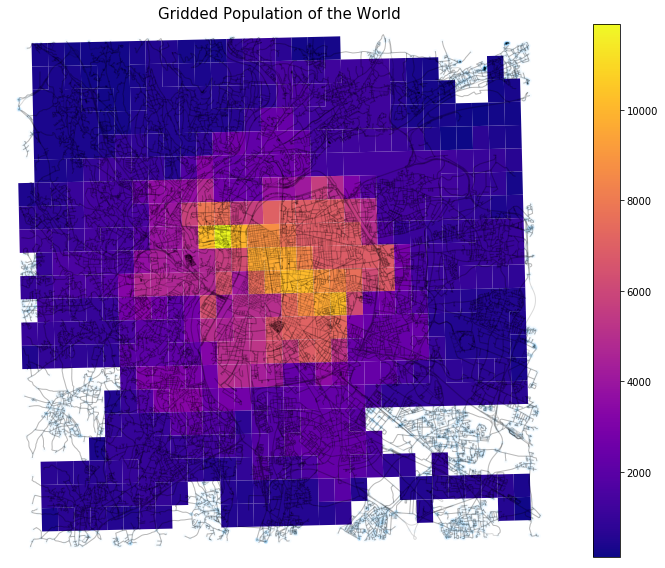

In [66]:
try:
    lyon_pop_gpw = us.get_extract_population_data(city_ref=city_ref, data_source="gpw", pop_shapefile=file_gpw_shapefile, to_crs=lyon_buildings.crs ,polygons_gdf=lyon_buildings)
    
    # Plot GPW
    fig, ax = ox.plot_graph(lyon_street_network, fig_height=figsize[1], fig_width=figsize[0], close=False, show=False, edge_color='black', edge_alpha=0.15, node_alpha=0.05)
    lyon_pop_gpw.plot("pop_count", ax=ax, cmap='plasma', legend=True)
    ax.set_title("Gridded Population of the World", fontsize=15)
    fig.tight_layout()
except:
    print('Skipping GPW extract')